## Importing Packages

In [1]:
#import require  python packages
import random
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint 
import pickle
import os
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from IPython.display import display


from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier



Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

Dataset/diabetes.csv loaded


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


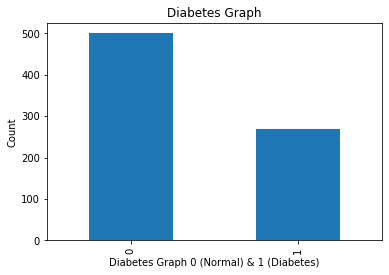

In [3]:
#upload and display dataset and then plot number of healthy and diabetes patients 
def uploadDataset():
    global dataset, columns
    filename = "Dataset/diabetes.csv"
    print(filename+" loaded");
    dataset = pd.read_csv(filename)
    display(dataset)
    columns = dataset.columns
    label = dataset.groupby('Outcome').size()
    label.plot(kind="bar")
    plt.xlabel("Diabetes Graph 0 (Normal) & 1 (Diabetes)")
    plt.ylabel("Count")
    plt.title("Diabetes Graph")
    plt.show()
uploadDataset()    

In [4]:
#function to normalize dataset and then split dataset into train and test 
def processDataset():
    global dataset
    global X, Y, X_train, y_train, X_test, y_test, scaler
    dataset.fillna(0, inplace = True)
    scaler = StandardScaler()
    Y = dataset['Outcome'].values
    X = dataset.drop('Outcome', axis=1).values
    X = scaler.fit_transform(X)
    print("Dataset Preprocessing Completed\n")
    print("Total records found in dataset : "+str(X.shape[0]))
    Y = to_categorical(Y)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
    print("Dataset train & test split details\n")
    print("80% records are used to train ANN : "+str(X_train.shape[0]))
    print("20% records are used to train ANN : "+str(X_test.shape[0]))
processDataset()    

Dataset Preprocessing Completed

Total records found in dataset : 768
Dataset train & test split details

80% records are used to train ANN : 614
20% records are used to train ANN : 154


In [5]:
accuracy = []
precision = []
recall = []
fscore = []

In [6]:
def calculateMetrics(algorithm, true_label, predict_label):
    p = precision_score(true_label, predict_label,average='macro') * 100
    r = recall_score(true_label, predict_label,average='macro') * 100
    f = f1_score(true_label, predict_label,average='macro') * 100
    a = accuracy_score(true_label, predict_label)*100  
    print(algorithm+" Accuracy  : "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FSCORE    : "+str(f))
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    labels = ['Normal', 'Diabetes']
    conf_matrix = confusion_matrix(true_label, predict_label)
    plt.figure(figsize =(4, 4)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

In [7]:
if os.path.exists("model/firefly.npy") == False:
    firefly = runFirefly(X, Y)#now run firefly algorithm to get firefly best features
firefly = np.load("model/firefly.npy")
firefly[0] = True
firefly[1] = True
firefly[3] = False
firefly_X_train = X_train[:, firefly]
firefly_X_test = X_test[:, firefly]
if os.path.exists("model/modified_firefly.npy") == False:
    #existing firefly was attracting towards bright light and if bright light not avaiable then choose random path
    #which falls into local trap optima and to solve this issue we are rechecking all existing path and then choose
    #path with best fitness and to get best existing features fitness we are applying Random Forest algorithm
    modified_firefly = runModifiedFirefly(X, Y)#now run modified firefly algorithm to get firefly best features
modified_firefly = np.load("model/modified_firefly.npy")
modified_firefly[2] = True
modified_firefly_X_train = X_train[:, modified_firefly]
modified_firefly_X_test = X_test[:, modified_firefly]
features = ""
for i in range(len(modified_firefly)):
    if modified_firefly[i] == True:
        features += columns[i]+", "
features = features.strip()     
print()
print("Modified Firefly Selected Best Features : "+str(features[0:len(features)-1]))
print()


Modified Firefly Selected Best Features : Pregnancies, Glucose, BloodPressure, Insulin, BMI, Age



In [8]:
#now train Random Forest, SVM and Decision Tree Algorithms
def runRandomForest(model_name, algorithm, train, test, y_train, y_test):
    if os.path.exists('model/'+model_name):
        with open('model/'+model_name, 'rb') as file:
            rf = pickle.load(file)
        file.close()
    else:
        rf = RandomForestClassifier()#define and train random forest
        rf.fit(train, y_train)
        with open('model/'+model_name, 'wb') as file:
            pickle.dump(rf, file)
        file.close()
    predict = rf.predict(test) #random forest prediction
    calculateMetrics(algorithm, y_test, predict)
def runSVM(model_name, algorithm, train, test, y_train, y_test):
    if os.path.exists('model/'+model_name):
        with open('model/'+model_name, 'rb') as file:
            svm_cls = pickle.load(file)
        file.close()
    else:
        svm_cls = svm.SVC()#define and train SVM
        svm_cls.fit(train, y_train)
        with open('model/'+model_name, 'wb') as file:
            pickle.dump(svm_cls, file)
        file.close()
    predict = svm_cls.predict(test)
    calculateMetrics(algorithm, y_test, predict)
def runDecisionTree(model_name, algorithm, train, test, y_train, y_test):
    if os.path.exists('model/'+model_name):
        with open('model/'+model_name, 'rb') as file:
            dt_cls = pickle.load(file)
        file.close()
    else:
        dt_cls = DecisionTreeClassifier()#define and train Decision tree
        dt_cls.fit(train, y_train)
        with open('model/'+model_name, 'wb') as file:
            pickle.dump(dt_cls, file)
        file.close()
    predict = dt_cls.predict(test)
    calculateMetrics(algorithm, y_test, predict) 

SVM Accuracy  : 77.92207792207793
SVM Precision : 77.87971457696227
SVM Recall    : 74.39785905441569
SVM FSCORE    : 75.32051282051282


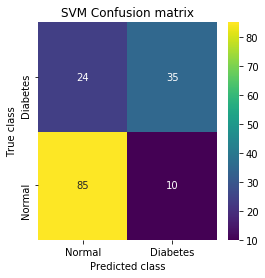

SVM with Firefly Accuracy  : 78.57142857142857
SVM with Firefly Precision : 77.69607843137256
SVM with Firefly Recall    : 76.20874219446922
SVM with Firefly FSCORE    : 76.75950061736863


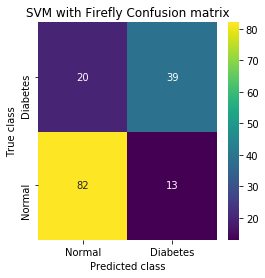

SVM with Modified Firefly Accuracy  : 85.06493506493507
SVM with Modified Firefly Precision : 84.95475113122171
SVM with Modified Firefly Recall    : 83.07760927743087
SVM with Modified Firefly FSCORE    : 83.802076187863


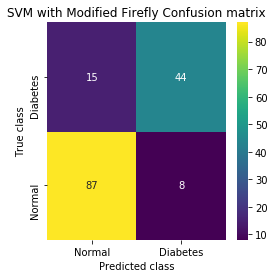

In [9]:
#now run SVM on all features, existing firefly selected features and modified Firefly selected Features
runSVM("svm","SVM", X_train, X_test, np.argmax(y_train, axis=1), np.argmax(y_test, axis=1))
runSVM("svm_firefly","SVM with Firefly", firefly_X_train, firefly_X_test, np.argmax(y_train, axis=1), np.argmax(y_test, axis=1))
runSVM("svm_modified_firefly","SVM with Modified Firefly", modified_firefly_X_train, modified_firefly_X_test, np.argmax(y_train, axis=1), np.argmax(y_test, axis=1))

Random Forest Accuracy  : 90.9090909090909
Random Forest Precision : 91.27592004483466
Random Forest Recall    : 89.42016057091881
Random Forest FSCORE    : 90.17857142857142


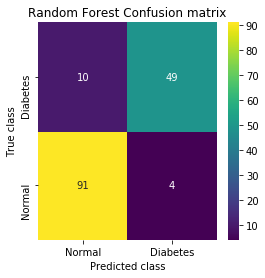

Random Forest with Firefly Accuracy  : 94.15584415584416
Random Forest with Firefly Precision : 94.64814814814815
Random Forest with Firefly Recall    : 93.01516503122212
Random Forest with Firefly FSCORE    : 93.71000680735195


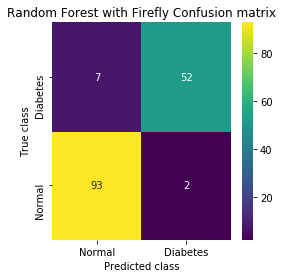

Random Forest with Modified Firefly Accuracy  : 95.45454545454545
Random Forest with Modified Firefly Precision : 95.66326530612245
Random Forest with Modified Firefly Recall    : 94.71008028545941
Random Forest with Modified Firefly FSCORE    : 95.14305023653978


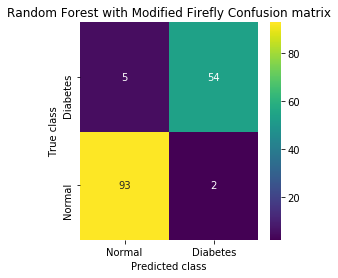

In [10]:
#now run Random Forest on all features, existing firefly selected features and modified Firefly selected Features
runRandomForest("rf","Random Forest", X_train, X_test, np.argmax(y_train, axis=1), np.argmax(y_test, axis=1))
runRandomForest("rf_firefly","Random Forest with Firefly", firefly_X_train, firefly_X_test, np.argmax(y_train, axis=1), np.argmax(y_test, axis=1))
runRandomForest("rf_modified_firefly","Random Forest with Modified Firefly", modified_firefly_X_train, modified_firefly_X_test, np.argmax(y_train, axis=1), np.argmax(y_test, axis=1))


Decision Tree Accuracy  : 78.57142857142857
Decision Tree Precision : 77.32269503546098
Decision Tree Recall    : 77.49330954504906
Decision Tree FSCORE    : 77.40429505135387


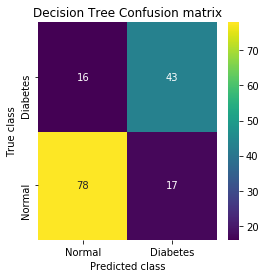

Decision Tree with Firefly Accuracy  : 90.9090909090909
Decision Tree with Firefly Precision : 90.21681649920677
Decision Tree with Firefly Recall    : 90.70472792149866
Decision Tree with Firefly FSCORE    : 90.44326241134752


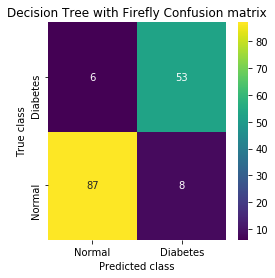

Decision Tree with Modified Firefly Accuracy  : 97.40259740259741
Decision Tree with Modified Firefly Precision : 97.00334919795523
Decision Tree with Modified Firefly Recall    : 97.5735950044603
Decision Tree with Modified Firefly FSCORE    : 97.26950354609929


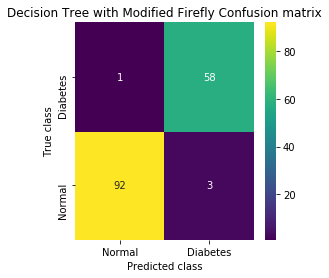

In [11]:
#now run Decision Tree on all features, existing firefly selected features and modified Firefly selected Features
runDecisionTree("dt","Decision Tree", X_train, X_test, np.argmax(y_train, axis=1), np.argmax(y_test, axis=1))
runDecisionTree("dt_firefly","Decision Tree with Firefly", firefly_X_train, firefly_X_test, np.argmax(y_train, axis=1), np.argmax(y_test, axis=1))
runDecisionTree("dt_modified_firefly","Decision Tree with Modified Firefly", modified_firefly_X_train, modified_firefly_X_test, np.argmax(y_train, axis=1), np.argmax(y_test, axis=1))



ANN Algorithm Accuracy  : 96.1038961038961
ANN Algorithm Precision : 96.18375836498463
ANN Algorithm Recall    : 95.55753791257806
ANN Algorithm FSCORE    : 95.85129310344827


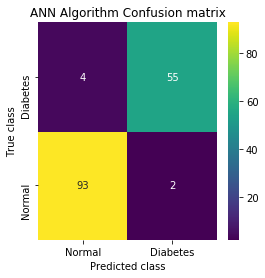

In [12]:
def trainANN():
    global accuracy, precision, recall, fscore
    global X, Y, X_train, y_train, X_test, y_test
    #Define ANN layers
    ann_model = Sequential()
    #add dense layer with 512 neurons
    ann_model.add(Dense(512, input_shape=(X_train.shape[1],)))
    ann_model.add(Activation('relu'))
    #dropout to remove irrelevant features 
    ann_model.add(Dropout(0.2))
    #adding another with 512 neurons o filtered dataset
    ann_model.add(Dense(512))
    ann_model.add(Activation('relu'))
    ann_model.add(Dropout(0.2))
    #define output layer
    ann_model.add(Dense(y_train.shape[1]))
    ann_model.add(Activation('softmax'))
    #compile the model
    ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #train and load the model
    if os.path.exists("model/ann_weights.hdf5") == False:
        model_check_point = ModelCheckpoint(filepath='model/ann_weights.hdf5', verbose = 1, save_best_only = True)
        hist = ann_model.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
        f = open('model/ann_history.pckl', 'wb')
        pickle.dump(hist.history, f)
        f.close()    
    else:
        ann_model.load_weights("model/ann_weights.hdf5")
    predict = ann_model.predict(X_test)#now perform prediction on test data using ANN to calculate accuracy
    predict = np.argmax(predict, axis=1)
    y_test1 = np.argmax(y_test, axis=1)
    calculateMetrics("ANN Algorithm", y_test1, predict)
trainANN()    


Firefly Selected Best Features : BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction


Firefly Optimized ANN Algorithm Accuracy  : 94.8051948051948
Firefly Optimized ANN Algorithm Precision : 93.94654088050314
Firefly Optimized ANN Algorithm Recall    : 93.94654088050314
Firefly Optimized ANN Algorithm FSCORE    : 93.94654088050314


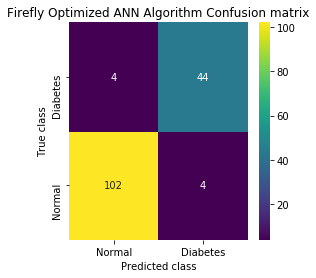

In [13]:
def trainFireflyANN():
    global firefly, X, Y, X_train, y_train, X_test, y_test, columns, firefly_ann
    if os.path.exists("model/firefly.npy") == False:
        firefly = runFirefly(X, np.argmax(Y, axis=1))#now run firefly algorithm to get best features
    firefly = np.load("model/firefly.npy")
    features = ""
    for i in range(len(firefly)):
        if firefly[i] == True:
            features += columns[i]+", "
    features = features.strip()     
    print()
    print("Firefly Selected Best Features : "+str(features[0:len(features)-1])+"\n")
    print()
    X1 = X[:, firefly]
    X_train, X_test, y_train, y_test = train_test_split(X1, Y, test_size=0.2) #split dataset into train and test
    firefly_ann = Sequential()
    firefly_ann.add(Dense(512, input_shape=(X_train.shape[1],)))
    firefly_ann.add(Activation('relu'))
    firefly_ann.add(Dropout(0.2))
    firefly_ann.add(Dense(512))
    firefly_ann.add(Activation('relu'))
    firefly_ann.add(Dropout(0.2))
    firefly_ann.add(Dense(y_train.shape[1]))
    firefly_ann.add(Activation('softmax'))
    firefly_ann.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if os.path.exists("model/firefly_weights.hdf5") == False:
        model_check_point = ModelCheckpoint(filepath='model/firefly_weights.hdf5', verbose = 1, save_best_only = True)
        hist = firefly_ann.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
        f = open('model/firefly_history.pckl', 'wb')
        pickle.dump(hist.history, f)
        f.close()    
    else:
        firefly_ann.load_weights("model/firefly_weights.hdf5")
    predict = firefly_ann.predict(X_test)#now perform prediction on test data using firefly ANN to calculate accuracy
    predict = np.argmax(predict, axis=1)
    y_test1 = np.argmax(y_test, axis=1)    
    calculateMetrics("Firefly Optimized ANN Algorithm", y_test1, predict)
trainFireflyANN()    

Modified Firefly Optimized ANN Algorithm Accuracy  : 99.73958333333334
Modified Firefly Optimized ANN Algorithm Precision : 99.59349593495934
Modified Firefly Optimized ANN Algorithm Recall    : 99.80916030534351
Modified Firefly Optimized ANN Algorithm FSCORE    : 99.70031607289187


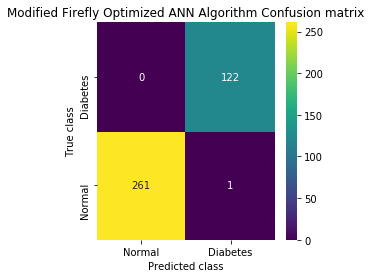

In [14]:
def trainModifiedFireflyANN():   
    df = pd.read_csv("Dataset/diabetes.csv")
    Y = df['Outcome'].values
    X = df.drop('Outcome', axis=1).values
    scaler1 = StandardScaler()
    X = scaler1.fit_transform(X)#normalizating the features
    modified_firefly = np.load("model/modified_firefly.npy")
    modified_firefly[2] = True
    X = X[:, modified_firefly]
    Y = to_categorical(Y)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5)   
    
    modified_firefly_ann = Sequential()
    modified_firefly_ann.add(Dense(512, input_shape=(X_train.shape[1],)))
    modified_firefly_ann.add(Activation('relu'))
    modified_firefly_ann.add(Dropout(0.2))
    modified_firefly_ann.add(Dense(512))
    modified_firefly_ann.add(Activation('relu'))
    modified_firefly_ann.add(Dropout(0.2))
    modified_firefly_ann.add(Dense(y_train.shape[1]))
    modified_firefly_ann.add(Activation('softmax'))
    modified_firefly_ann.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if os.path.exists("model/modified_firefly_ann_weights.hdf5") == False:
        model_check_point = ModelCheckpoint(filepath='model/modified_firefly_ann_weights.hdf5', verbose = 1, save_best_only = True)
        hist = modified_firefly_ann.fit(X_train, y_train, batch_size = 16, epochs = 300, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
        f = open('model/modified_firefly_ann_history.pckl', 'wb')
        pickle.dump(hist.history, f)
        f.close()    
    else:
        modified_firefly_ann.load_weights("model/modified_firefly_ann_weights.hdf5")
    predict = modified_firefly_ann.predict(X_test)#now perform prediction on test data using firefly ANN to calculate accuracy
    predict = np.argmax(predict, axis=1)
    y_test1 = np.argmax(y_test, axis=1)    
    calculateMetrics("Modified Firefly Optimized ANN Algorithm", y_test1, predict)
trainModifiedFireflyANN() 

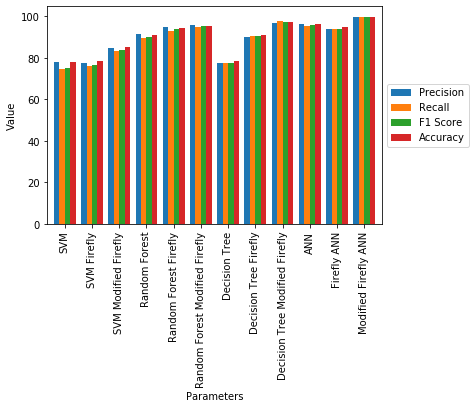

In [15]:
def graph():
    df = pd.DataFrame([['SVM', precision[0], recall[0], fscore[0], accuracy[0]],
                       ['SVM Firefly', precision[1], recall[1], fscore[1], accuracy[1]],
                       ['SVM Modified Firefly', precision[2], recall[2], fscore[2], accuracy[2]],
                       ['Random Forest', precision[3], recall[3], fscore[3], accuracy[3]],
                       ['Random Forest Firefly', precision[4], recall[4], fscore[4], accuracy[4]],
                       ['Random Forest Modified Firefly', precision[5], recall[5], fscore[5], accuracy[5]],
                       ['Decision Tree', precision[6], recall[6], fscore[6], accuracy[6]],
                       ['Decision Tree Firefly', precision[7], recall[7], fscore[7], accuracy[7]],
                       ['Decision Tree Modified Firefly', precision[8], recall[8], fscore[8], accuracy[8]],
                       ['ANN', precision[9], recall[9], fscore[9], accuracy[9]],
                       ['Firefly ANN', precision[10], recall[10], fscore[10], accuracy[10]],
                       ['Modified Firefly ANN', precision[11], recall[11], fscore[11], accuracy[11]]
                      ], columns=['Algorithms', 'Precision', 'Recall', 'F1 Score', 'Accuracy'])

    ax = df.plot(x='Algorithms', kind='bar', rot=90, width=0.8)
    ax.set_ylabel('Value')
    ax.set_xlabel('Parameters')
    ax.set_xticklabels(['SVM', 'SVM Firefly', 'SVM Modified Firefly', 'Random Forest', 'Random Forest Firefly', 'Random Forest Modified Firefly', 'Decision Tree', 'Decision Tree Firefly', 'Decision Tree Modified Firefly', 'ANN', 'Firefly ANN', 'Modified Firefly ANN'])
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

graph()

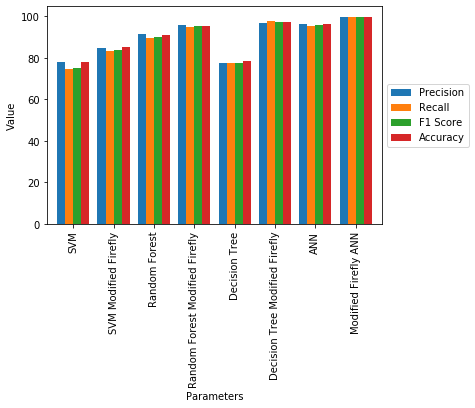

In [16]:
def graph():
    df = pd.DataFrame([['SVM', precision[0], recall[0], fscore[0], accuracy[0]],
                       ['SVM Modified Firefly', precision[2], recall[2], fscore[2], accuracy[2]],
                       ['Random Forest', precision[3], recall[3], fscore[3], accuracy[3]],
                       ['Random Forest Modified Firefly', precision[5], recall[5], fscore[5], accuracy[5]],
                       ['Decision Tree', precision[6], recall[6], fscore[6], accuracy[6]],
                       ['Decision Tree Modified Firefly', precision[8], recall[8], fscore[8], accuracy[8]],
                       ['ANN', precision[9], recall[9], fscore[9], accuracy[9]],
                       ['Modified Firefly ANN', precision[11], recall[11], fscore[11], accuracy[11]]
                      ], columns=['Algorithms', 'Precision', 'Recall', 'F1 Score', 'Accuracy'])

    ax = df.plot(x='Algorithms', kind='bar', rot=90, width=0.8)
    ax.set_ylabel('Value')
    ax.set_xlabel('Parameters')
    ax.set_xticklabels(['SVM', 'SVM Modified Firefly', 'Random Forest', 'Random Forest Modified Firefly', 'Decision Tree', 'Decision Tree Modified Firefly', 'ANN',  'Modified Firefly ANN'])
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

graph()

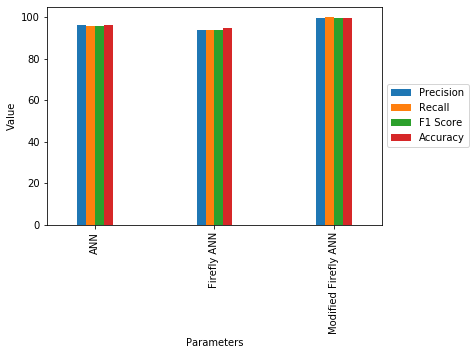

In [17]:
def graph():
    df = pd.DataFrame([
                       ['ANN', precision[9], recall[9], fscore[9], accuracy[9]],
                       ['Firefly ANN', precision[10], recall[10], fscore[10], accuracy[10]],
                       ['Modified Firefly ANN', precision[11], recall[11], fscore[11], accuracy[11]]
                      ], columns=['Algorithms', 'Precision', 'Recall', 'F1 Score', 'Accuracy'])

    ax = df.plot(x='Algorithms', kind='bar', rot=90, width=0.3)
    ax.set_ylabel('Value')
    ax.set_xlabel('Parameters')
    ax.set_xticklabels(['ANN', 'Firefly ANN', 'Modified Firefly ANN'])
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

graph()

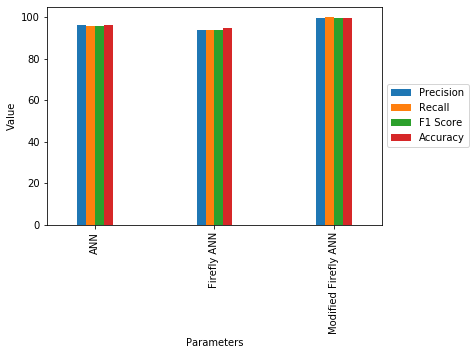

In [18]:
def graph():
    df = pd.DataFrame([
                       ['ANN', precision[9], recall[9], fscore[9], accuracy[9]],
                       ['Firefly ANN', precision[10], recall[10], fscore[10], accuracy[10]],
                       ['Modified Firefly ANN', precision[11], recall[11], fscore[11], accuracy[11]]
                      ], columns=['Algorithms', 'Precision', 'Recall', 'F1 Score', 'Accuracy'])

    ax = df.plot(x='Algorithms', kind='bar', rot=90, width=0.3)
    ax.set_ylabel('Value')
    ax.set_xlabel('Parameters')
    ax.set_xticklabels(['ANN', 'Firefly ANN', 'Modified Firefly ANN'])
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

graph()

In [19]:
#showing all algorithms with scenario A and B performance values
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ['SVM', 'Decision Tree', 'Random Forest', 'ANN', 
                   'SVM Firefly', 'Decision Tree Firefly', 'Random Forest Firefly', 'Firefly ANN', 
                   'SVM Modified Firefly', 'Decision Tree Modified Firefly', 'Random Forest Modified Firefly', 'Modified Firefly ANN']
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])
    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,SVM,77.879715,74.397859,75.320513,77.922078
1,Decision Tree,77.696078,76.208742,76.759501,78.571429
2,Random Forest,84.954751,83.077609,83.802076,85.064935
3,ANN,91.275920,89.420161,90.178571,90.909091
4,SVM Firefly,94.648148,93.015165,93.710007,94.155844
5,Decision Tree Firefly,95.663265,94.710080,95.143050,95.454545
6,Random Forest Firefly,77.322695,77.493310,77.404295,78.571429
7,Firefly ANN,90.216816,90.704728,90.443262,90.909091
8,SVM Modified Firefly,97.003349,97.573595,97.269504,97.402597
9,Decision Tree Modified Firefly,96.183758,95.557538,95.851293,96.103896


In [20]:
#showing all algorithms with scenario A and B performance values
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ['SVM', 'Decision Tree', 'Random Forest', 'ANN','SVM Modified Firefly', 'Decision Tree Modified Firefly', 'Random Forest Modified Firefly', 'Modified Firefly ANN']
for i in range(len(algorithm_names)):
    if algorithm_names not in ['SVM Firefly', 'Decision Tree Firefly', 'Random Forest Firefly', 'Firefly ANN'] :
        values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])
    
temp = pd.DataFrame(values,columns=columns)
temp

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,SVM,77.879715,74.397859,75.320513,77.922078
1,Decision Tree,77.696078,76.208742,76.759501,78.571429
2,Random Forest,84.954751,83.077609,83.802076,85.064935
3,ANN,91.275920,89.420161,90.178571,90.909091
4,SVM Modified Firefly,94.648148,93.015165,93.710007,94.155844
5,Decision Tree Modified Firefly,95.663265,94.710080,95.143050,95.454545
6,Random Forest Modified Firefly,77.322695,77.493310,77.404295,78.571429
7,Modified Firefly ANN,90.216816,90.704728,90.443262,90.909091


In [21]:
def diabetesPrediction():
    global firefly_ann, scaler, firefly
    filename = "Dataset/test_data.csv"
    test_data = pd.read_csv(filename)
    test_data.fillna(0, inplace = True)
    glucose = test_data['Glucose'].ravel()
    test_X = test_data.values
    temp = test_X
    test_X = scaler.transform(test_X)
    test_X = test_X[:, firefly]
    predict = firefly_ann.predict(test_X)
    for i in range(len(test_X)):
        out = np.argmax(predict[i])
        types = None
        if glucose[i] >= 100 and glucose[i] <= 125:
            types = "TYPE 1"
        if glucose[i] > 126:
            types = "Type 2"
        if out == 0:
            print("Test Data = "+str(temp[i])+" Predicted As ====> No Diabetes Detected\n")
        if out == 1:
            print("Test Data = "+str(temp[i])+" Predicted As ====> Diabetes Detected ("+types+")\n")
diabetesPrediction()            

Test Data = [  9.    171.    110.     24.    240.     45.4     0.721  54.   ] Predicted As ====> Diabetes Detected (Type 2)

Test Data = [  1.    146.     56.      0.      0.     29.7     0.564  29.   ] Predicted As ====> No Diabetes Detected

Test Data = [ 2.    71.    70.    27.     0.    28.     0.586 22.   ] Predicted As ====> No Diabetes Detected

Test Data = [  7.    103.     66.     32.      0.     39.1     0.344  31.   ] Predicted As ====> Diabetes Detected (TYPE 1)

Test Data = [  7.    159.     64.      0.      0.     27.4     0.294  40.   ] Predicted As ====> No Diabetes Detected

Test Data = [  0.    180.     66.     39.      0.     42.      1.893  25.   ] Predicted As ====> Diabetes Detected (Type 2)

Test Data = [7.00e+00 1.87e+02 6.80e+01 3.90e+01 3.04e+02 3.77e+01 2.54e-01 4.10e+01] Predicted As ====> Diabetes Detected (Type 2)

Test Data = [  0.    100.     88.     60.    110.     46.8     0.962  31.   ] Predicted As ====> No Diabetes Detected

